In [1]:
import networkExpansionPy.lib as ne
import numpy as np
import pandas as pd
import pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr,pearsonr,mannwhitneyu
from statsmodels.stats.multitest import multipletests
plt.rcParams['font.family'] = 'Arial'
import pingouin as pg
import re
from scipy.stats import fisher_exact

import warnings
from scipy.sparse import (spdiags, SparseEfficiencyWarning, csc_matrix,
    csr_matrix, isspmatrix, dok_matrix, lil_matrix, bsr_matrix)
warnings.simplefilter('ignore',SparseEfficiencyWarning)

def load_data(network_name):
    with open(ne.asset_path  + "/metabolic_networks/" + network_name,"rb") as filehandler:
        metabolism = pickle.load(filehandler)
    return metabolism

# load the metabolism object from the repo
model_id = "metabolism.v8.01May2023.pkl"
metabolism = pd.read_pickle('/Users/joshuagoldford/Documents/github/network-expansion-assets/models/' + model_id)
cids = metabolism.coenzymes


seed = pd.read_csv('../assets/seed_set.csv')


In [2]:
import json
with open(ne.asset_path + "/KEGG/compound.json") as jsonfile:
    compounds = json.load(jsonfile)


In [6]:
pathway_data = pd.read_csv("data/random_seed_sets_pathway_ordering/09May2023/pathway_results.csv",index_col=0)

In [23]:
module_names = {}
module_names['M00165'] = 'Calvin cycle'
module_names['M00173'] = 'rTCA'
module_names['M00374'] = 'DC/HB'
module_names['M00375'] = 'HP/HB'
module_names['M00376'] = '3HP'
module_names['M00377'] = 'Reductive acetyl-CoA \n pathway'
module_names['ReductiveGlycineModule'] = 'Reductive glycine \n pathway'
pathway_data["module name"] = pathway_data["module"].apply(lambda x: module_names[x])

In [24]:
pm = pathway_data.pivot_table(index="sample",columns = "module name",values="iteration")
pm = pm[["Calvin cycle","rTCA","Reductive glycine \n pathway","Reductive acetyl-CoA \n pathway",'DC/HB','HP/HB','3HP']]

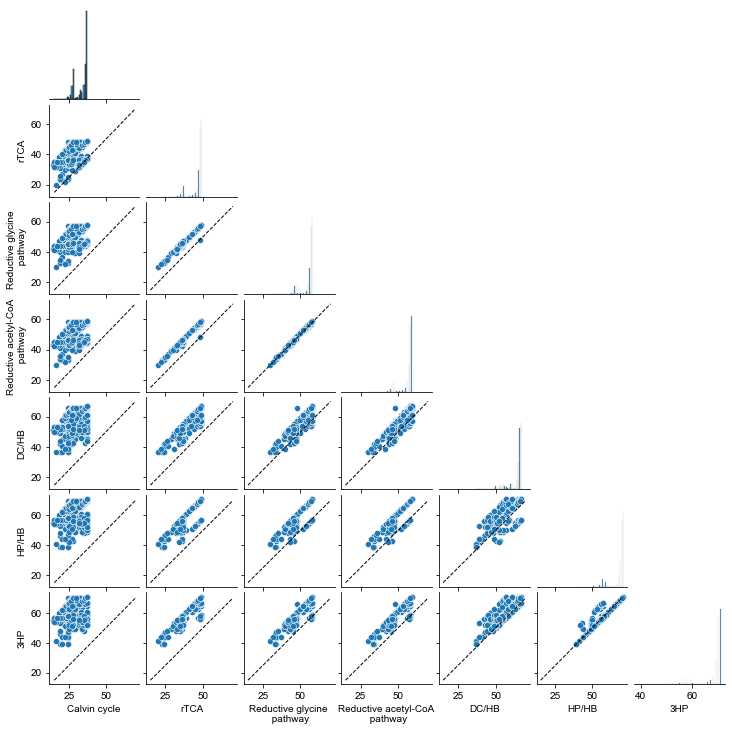

In [47]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mn = 15
    mx = max(xdata.max(), ydata.max())
    mx = 70
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)

grid = sns.pairplot(pm,corner=True)
grid.map_offdiag(plot_unity)
grid.fig.set_size_inches(10,10)
#plt.savefig("

In [36]:
seeds = pd.read_pickle("data/random_seed_sets_pathway_ordering/09May2023/seed_sets.pkl")

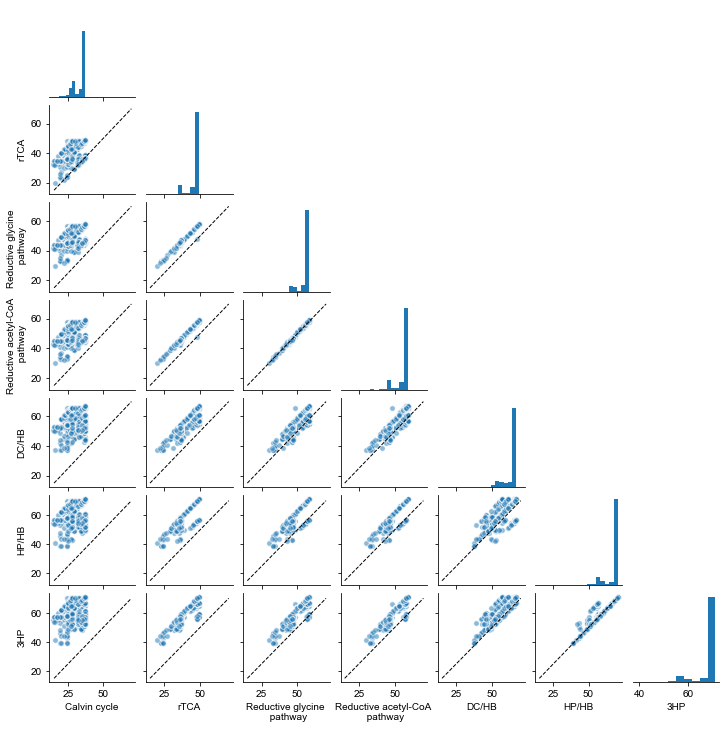

In [169]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def plot_unity(xdata, ydata, **kwargs):
    mn = min(xdata.min(), ydata.min())
    mn = 15
    mx = max(xdata.max(), ydata.max())
    mx = 70
    points = np.linspace(mn, mx, 100)
    plt.gca().plot(points, points, color='k', marker=None,
            linestyle='--', linewidth=1.0)

    
# Create a custom rasterizing function
def rasterize_points(x, y, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    # Set rasterization_zorder to rasterize points below this z-order value
    kwargs["rasterized"] = 1
    ax.scatter(x, y, **kwargs)

# Create a pair plot using the custom rasterizing function
g = sns.PairGrid(pm,corner=True)
g.map_diag(plt.hist)  # Show histograms on the diagonal
g.map_offdiag(rasterize_points, s=30, edgecolor="w", alpha=0.5)
g.map_offdiag(plot_unity)
g.fig.set_size_inches(10,10)
plt.savefig("figs/random_seed_set_pairplot.pathways.svg")

In [59]:
samples_match = pm[pm["rTCA"] == pm["Calvin cycle"]].index.tolist()
samples_nomatch = pm[pm["rTCA"] != pm["Calvin cycle"]].index.tolist()
seeds["Eq"] = pm["rTCA"] == pm["Calvin cycle"]

In [71]:
seed_adds = list(set(list([item for sublist in seeds.seeds.tolist() for item in sublist])))

In [72]:
len(seed_adds)

1807

In [114]:
# compute enrichment stats for each metabolite

results = {"cid":[],"enrich_in_collaposed":[],"enrich_in_other":[],"fstat":[],"pval":[]}

for x in seed_adds:
    seeds["query"]= seeds.seeds.apply(lambda y: x in y)
    c = pd.crosstab(seeds["Eq"],seeds["query"])
    if len(list(c))>1:
        if len(c) > 1:
            f = c.loc[True].loc[True] / (c.loc[True].loc[True] +   c.loc[True].loc[False] )
            fn = c.loc[False].loc[True] / (c.loc[False].loc[True] +   c.loc[False].loc[False] )
            stats,pval = fisher_exact(c)
            results["cid"].append(x)
            results["enrich_in_collaposed"].append(f)
            results["enrich_in_other"].append(fn)
            results["fstat"].append(stats)
            results["pval"].append(pval)

In [115]:
results = pd.DataFrame(results)

In [122]:
from statsmodels.stats.multitest import multipletests


# perform the Benjamini-Hochberg correction
corrected_pvals = multipletests(results.pval.values, method='fdr_bh')[1]
results["adj pval"] = corrected_pvals
results["adj. p-val (-log10)"] = results["adj pval"].apply(lambda x: -1*np.log10(x))
results["log2enrich"] = np.log2((results["enrich_in_collaposed"] + 1e-4) / (results["enrich_in_other"] + 1e-4))

In [141]:
md2cpd = pd.read_csv('../assets/KEGG_ModuleVsCompound.csv')

In [158]:
mods = ["M00019","M00119","M00913"]
cids_to_color = md2cpd[md2cpd.module.isin(mods)].cid.unique().tolist()
results["pathway"]= results.cid.isin(cids_to_color)

/Users/joshuagoldford/opt/miniconda3/envs/ne.py3.6/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


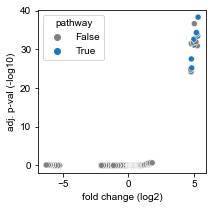

In [198]:
plt.figure(figsize=(3,3))
cmap = sns.color_palette("Paired")
colors = ["grey",cmap[1]]

g = sns.scatterplot(x="log2enrich",y="adj. p-val (-log10)",data=results.sort_values("pval",ascending=False),hue="pathway",palette=colors,rasterized=True)
plt.xlabel("fold change (log2)")
plt.savefig("figs/rTCA_vs_Calvin_Timing_VolcanoPlot.svg")


There were 71 compounds in this seed set...
There were 4315 compounds produced in this expansion!


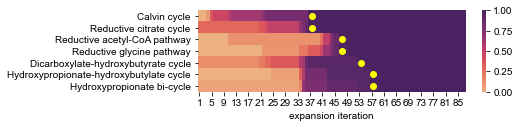

In [174]:
seed_set = pd.read_csv('../assets/seed_set.csv')['ID'].tolist() + ["C00183"]
#seed_df = pd.read_csv('assets/seed_set.csv')
#seed_set = seed_df[~seed_df.Type.isin(["Organic carbon"])].ID.tolist()
#seed_set = seed_set + ["C00010"]

print('There were {N} compounds in this seed set...'.format(N=len(seed_set)))

ne_cpds,ne_rxns = metabolism.expand(seed_set,algorithm='trace')
print('There were {N} compounds produced in this expansion!'.format(N=len(ne_cpds)))

# parse data into dataframes
rn_df = pd.DataFrame(pd.Series(ne_rxns),columns = ['iteration'])
rn_df.reset_index(inplace=True)
rn_df.columns = ['rn','direction','iteration']
rn_df['rn_kegg']= rn_df['rn'].apply(lambda x: x.split('_')[0])

carbon_fixation = ['M00165','M00173','M00374','M00375','M00376','M00377','ReductiveGlycineModule']

module_set = pd.read_csv('../assets/carbonFixationModuleRules.v2.csv')
# this is a biotin-dependent step, whcih can be performed via PEP carboxylase which always occurs earlier
module_set = module_set[~(module_set["step"] == "C00022 -> C00036")]
module_names = {}
module_names['M00165'] = 'Calvin cycle'
module_names['M00173'] = 'Reductive citrate cycle'
module_names['M00374'] = 'Dicarboxylate-hydroxybutyrate cycle'
module_names['M00375'] = 'Hydroxypropionate-hydroxybutylate cycle'
module_names['M00376'] = 'Hydroxypropionate bi-cycle'
module_names['M00377'] = 'Reductive acetyl-CoA pathway'
module_names['ReductiveGlycineModule'] = 'Reductive glycine pathway'

iterations = rn_df.iteration.unique().tolist()
module_coverage = {'module':[],'iteration':[],'coverage':[]}


# make a reaction df with ONLY extant reactions
rn_df_extant = rn_df[~rn_df.rn.apply(lambda x: ("H2Red" in x) | ("_RSH" in x))]


for i in iterations:
    rsub = rn_df_extant[rn_df_extant.iteration < (i+1)]
    #rsub =rn_df[rn_df.iteration < (i+1)]
    rsub = rsub.rn_kegg.unique()
    for module,mdf in module_set.groupby('module'):
        z = mdf.reactions.apply(lambda x: any([y in rsub for y in x.split(',')]))
        coverage = z.sum() / len(z)
        module_coverage['module'].append(module)
        module_coverage['iteration'].append(i)
        module_coverage['coverage'].append(coverage)

module_coverage = pd.DataFrame(module_coverage)
module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

M00357 = pd.DataFrame(module_coverage_piv[['M00357.v1','M00357.v2']].max(axis=1))
M00357.columns = ['coverage']
M00357['module'] = 'M00357'

module_coverage = pd.concat([module_coverage,M00357.reset_index()[['module','iteration','coverage']]],axis=0)
module_coverage_piv = module_coverage.pivot_table(index='iteration',columns='module',values='coverage')

pathway_completion_iteration = pd.Series({x:y[y.coverage == 1].iteration.min() for x,y in module_coverage.groupby('module')})

height = 6
mods = carbon_fixation
q = pd.DataFrame(pathway_completion_iteration.loc[mods].sort_values(),columns = ['iteration']).reset_index().reset_index()
q.columns = ['rank','module','iteration']
mods = pathway_completion_iteration.loc[mods].sort_values().index.tolist()
n = len(mods)
plt.figure(figsize=(height,(n/2)/14*height))

z = module_coverage_piv[mods].T
z.index = [module_names[x] for x in z.index.tolist()]

ax = sns.heatmap(z,cmap='flare',yticklabels=True)
plt.yticks(rotation=0)

#y = q['rank'].values + (n/2 / 10)
y = ax.get_yticks()

x = q['iteration'].values
plt.scatter(x,y,color='yellow')
plt.xlabel('expansion iteration')
#plt.savefig('carbonfixation.{date}.svg'.format(date=date))
plt.savefig("figs/fig4c_valine.svg")
